# Daily Revenue Forecasting
### Background
Why a daily forcasting on demand is necessary? It is usually important when economies of scale is unlikely for a business (for example, barber shop). When demand increase, additional resources is required to meet the demand. Understanding the structure in daily demand can help operations team better plan for times with resource constraints.

### Goal
The analysis aims to forecast daily revenue of a start-up service provider. <br>
It is a perfect practice for the forecasting methodology I learned through [Lyft Engineering Blog](https://eng.lyft.com/how-to-deal-with-the-seasonality-of-a-market-584cc94d6b75).

### Data source
A friend generous enough to provide the data 🥳

### Dependencies:
```
holidays >= 0.11.0
numpy >= 1.20.0
pandas >= 1.2.0
scikit-learn>=0.24.0
seaborn >= 0.11.1
simdkalman >= 1.0.0
```

In [1]:
import holidays
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import seaborn as sns
import simdkalman
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.nonparametric.smoothers_lowess import lowess

pd.options.mode.chained_assignment = None  # avoid warnings for chained assignment

# hide warnings for readability
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/revenue_forecasting/daily_revenue.csv')
data['date'] = pd.to_datetime(data['date'])

## Data exploration

In [3]:
print('First date in data: ', data['date'].min())
print('Last date in data: ', data['date'].max())

First date in data:  2014-08-01 00:00:00
Last date in data:  2019-07-21 00:00:00


Text(0.5, 1.0, 'Daily Revenue')

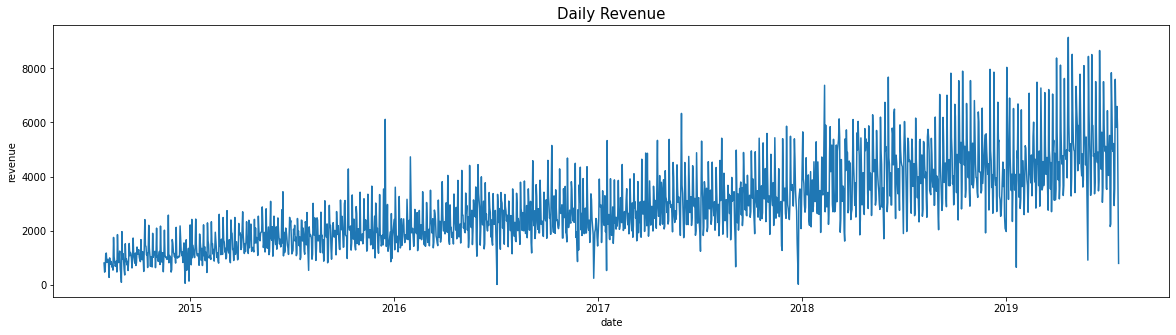

In [4]:
plt.figure(figsize=(20,5))
sns.lineplot(x='date', y='revenue', data=data)
plt.title('Daily Revenue', fontsize=15)

Text(0.5, 1.0, 'Daily Revenue, Weekly Fluctuation')

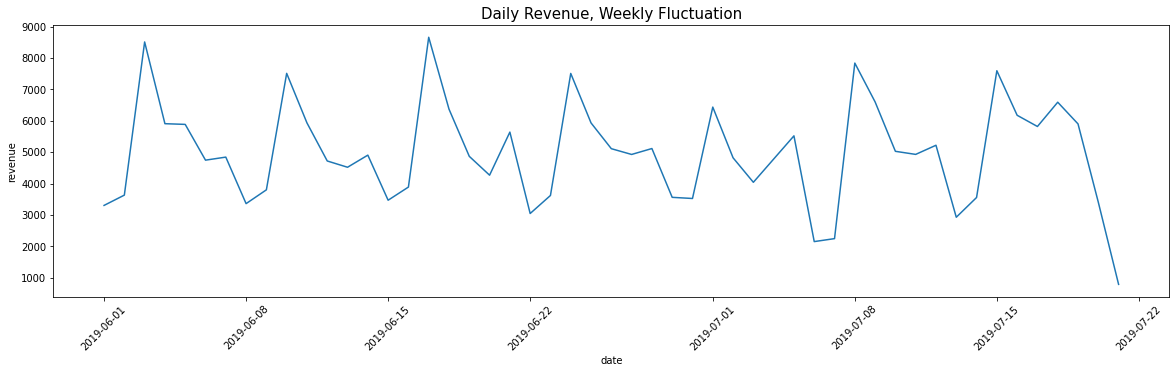

In [5]:
plt.figure(figsize=(20,5))
sns.lineplot(x='date', y='revenue', data=data[data['date']>='2019-06-01'])
_ = plt.xticks(rotation = 45)
plt.title('Daily Revenue, Weekly Fluctuation', fontsize=15)

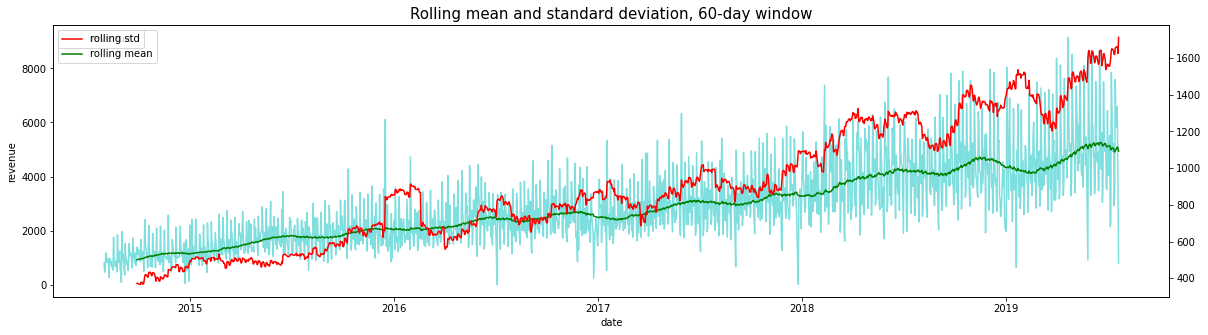

In [6]:
# plot rolling mean and variance
rolling_mean = data['revenue'].rolling(60).mean().values
rolling_std = data['revenue'].rolling(60).std().values

plt.figure(figsize=(20, 5))

ax1 = sns.lineplot(x='date', y='revenue', data=data, color='c', label='revenue', alpha=0.5)
ax2 = sns.lineplot(x=data['date'], y=rolling_mean, color='g', label='rolling mean')
ax3 = ax2.twinx()
ax3 = sns.lineplot(x=data['date'], y=rolling_std, color='r', label='rolling std')
plt.title('Rolling mean and standard deviation, 60-day window', fontsize=15)
plt.legend()

Through plotting the time series, we clearly see some characteristics of this data:
- Obvious growth trend (typical for start-ups)
- Some annual seasonality (partially masked by fast growth, but looks like revenue during spring/autumn is higher)
- Strong weekly seasonality (peak at Mondays, then gradually decrease throughout the week)
- Noticeable outliers on the lower end (most likely driven by holidays, similar to lowest revenue on Sundays)
- Larger standard deviation along with revenue growth (indicate that multiplicative decomposition may work better)
<br>

Thefore, when considering a forecasting strategy, we need to take care of:
- A good, dynamic trend forecast
- Multiple seasonality
- Holidays

The plan is to tackle each of the component separately. 

## Forecasting model

### Split train-test period


In [7]:
# Use a full year as test data
test_cutoff = '2018-08-01'

test_data = data[ data['date'] >= test_cutoff ]
train_data = data[ data['date'] < test_cutoff ]

### Remove trend
While the seasonality is multiplicative one, working with logs of the time series allows us to use additive seasonality. <br>
<br>
We use LOWESS (Locally Weighted Scatterplot Smoothing) to get trend of log revenue.

In [8]:
train_data['log_revenue'] = np.log1p(train_data['revenue'])
test_data['log_revenue'] = np.log1p(test_data['revenue'])

In [9]:
def get_trend(ts, index, lowess_frac=0.4):
    '''
    Separate trend and residuals from a time series with LOWESS. 

    Args:
        ts (array-like): time series.
        index (array-like): timestamp of the time series.
        lowess_frac (float): Between 0 and 1. The fraction of the closest data used when estimating.


    Returns:
        trend (array-like): additive trend.
        resid (array-like): residuals after removing the trend.
    '''
    lowess_smoothed = lowess(endog=ts, exog=index, frac=lowess_frac, return_sorted=False)
    return lowess_smoothed, ts-lowess_smoothed

lowess_frac = 0.3

train_data['log_trend'], train_data['log_detrend'] = \
    get_trend(train_data['log_revenue'], train_data['date'], 
              lowess_frac=lowess_frac)

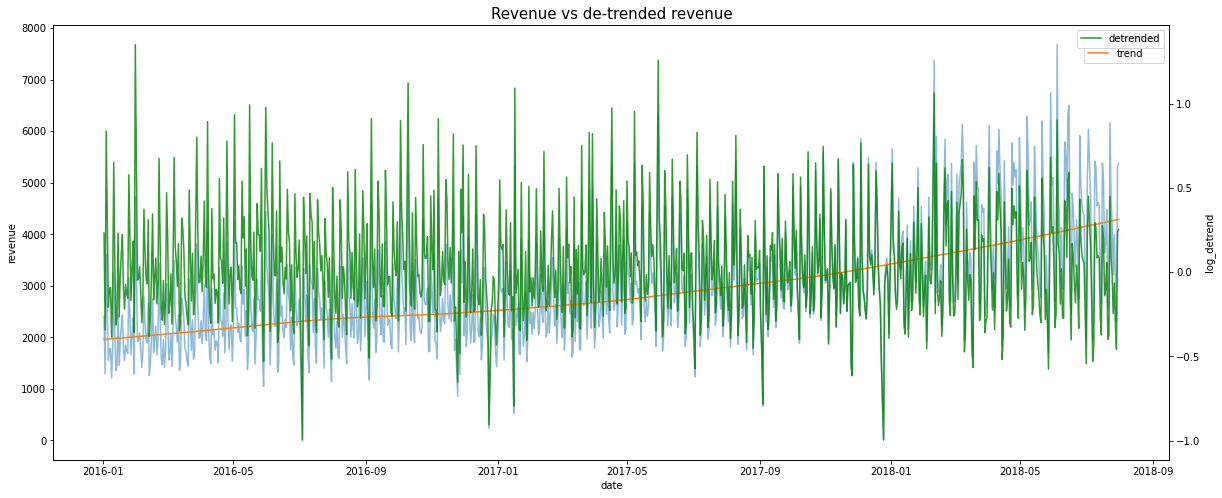

In [10]:
# plot de-trended vs original
plt.figure(figsize=(20,8))

plot_data = train_data[ train_data['date'] >= '2016-01-01' ]
ax1 = sns.lineplot(x='date', y='revenue', data=plot_data, label="revenue ", alpha=0.5)
ax2 = sns.lineplot(x=plot_data['date'], y=np.expm1(plot_data['log_trend']), label="trend")
ax3 = ax2.twinx()
ax3 = sns.lineplot(x=plot_data['date'], y=np.expm1(plot_data['log_detrend']), label="detrended", color='g', alpha=0.8)
plt.title('Revenue vs de-trended revenue', fontsize=15)
plt.legend()

### Weekly seasonality: A state transition model

Implemented using python library [sidmankalman](https://github.com/oseiskar/simdkalman). [Here](https://simdkalman.readthedocs.io/en/latest/) is the documentation with a brief introduction on Kalman Filters.

In [11]:
# define state space model. 
# tunable hyperparameters: season noise and observation noise. The larger the noise, the smoothier the seasonality will be (residuals will be noisier).
class StateTransitionModel():
    def __init__(self, n_season, season_noise, observation_noise):
        """
        Initiate a state space model (fitted with Kalman Filter).

        Args:
            n_season (int): number of periods that form a cycle of seasonality.
            season_noise (float): noise parameter for process noise (on seasonality only). Equal to 0.0 will lead to singular matrix.
            observation_noise (float): noise parameter for observation noise.
        """
        self._n_season = n_season
        self._season_noise = season_noise
        self._obs_noise = observation_noise

        # observation model H
        self._H = [[1] + [0]*(self._n_season-1)]

        # state transition model A
        self._A = np.zeros((self._n_season, self._n_season))
        self._A[0,:-1] = [-1.0] * (self._n_season-1) # transition of one week
        self._A[1:,:-1] = np.eye(self._n_season-1)

        # process noise Q
        self._Q = np.diag([self._season_noise]*(self._n_season))

        # observation noise R
        self._R = self._obs_noise

        # initiate Kalman Filter
        self._kf_model = simdkalman.KalmanFilter(
                            state_transition = self._A,
                            process_noise = self._Q,
                            observation_model = self._H,
                            observation_noise = self._R
                            )

    def fit(self, X):
        """Fit the Kalman Filter.
        
        Args:
            X (array-like): time series to be fitted.
        """
        self.X = X
        self._smoothed_res = self._kf_model.smooth(X)
        self.smoothed_mean = self._smoothed_res.observations.mean
        self.smoothed_std = np.sqrt(self._smoothed_res.observations.cov)

    def predict(self, n_step):
        """Predict n_steps.
        
        Args:
            n_step (int): number of steps ahead to predict.

        Returns:
            pred (1d array): point estimate of predictions.
            pred_std (1d array): standard error of predictions.
        """ 
        _predict_res = self._kf_model.predict(self.X, n_step)
        
        pred = _predict_res.observations.mean
        pred_std = _predict_res.observations.cov
        
        return pred, pred_std


In [12]:
kf = StateTransitionModel(n_season=7, season_noise=0.01, observation_noise=0.01)

kf.fit(train_data['log_detrend'].values)

#spred, pred_std = kf.predict(28)

train_data['log_weekly_seasonality'] = kf.smoothed_mean

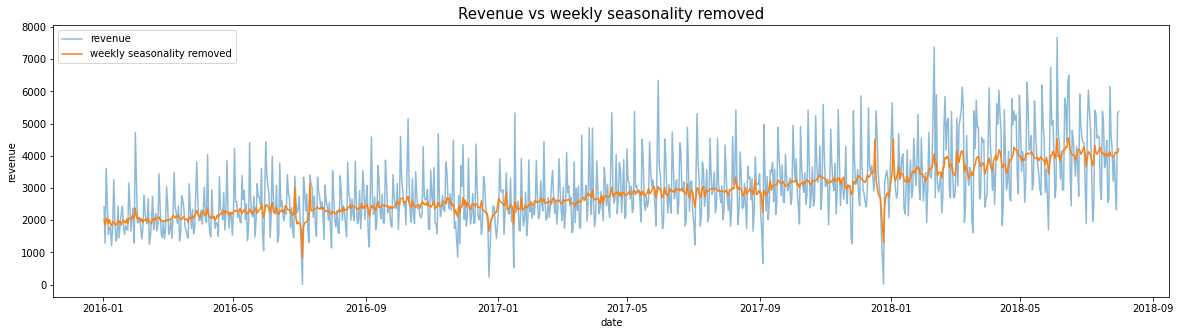

In [13]:
# plot smoothed and predicted weekly seasonality
plt.figure(figsize=(20,5))

plot_data = train_data[ train_data['date']>='2016-01-01' ]
resid = np.expm1(plot_data['log_revenue'] - plot_data['log_weekly_seasonality'])
trend_and_seasonality = np.expm1(plot_data['log_weekly_seasonality'] + plot_data['log_trend'])

ax1 = sns.lineplot(x=plot_data['date'], y=plot_data['revenue'], label='revenue', alpha=0.5)
ax2 = sns.lineplot(x=plot_data['date'], y=resid, label='weekly seasonality removed')

plt.title('Revenue vs weekly seasonality removed', fontsize=15)
plt.legend()

After removing weekly seasonality, there are still some outliers in the residual, some of which are likely driven by holidays. To identify major U.S. holidays, I use the `holidays` library ([documentation](https://pypi.org/project/holidays/)). Additional holidays not needed can be customized too. <br>
<br>
Holidays and yearly seasonality are modeled together:
- Holidays can be encoded as binary variable;
- Yearly seasonality can be viewed as a function based on day of year.

In [14]:
us_holidays = holidays.UnitedStates()

def mark_holidays(date_arr):
    """Mark holidays for a given date array.

    Args:
        date_arr (array-like): array of datetime.
    
    Returns:
        holiday_dummies (pd.DataFrame): one-hot encoded holiday flag
    """
    holiday_flag = list(map(lambda s: int(s in us_holidays), date_arr))
    day_after_holiday_flag = [0] + holiday_flag[:-1]
    day_before_holiday_flag = holiday_flag[1:] + [0]

    # create one-hot encoded holiday flag
    holiday_series = list(map(lambda s: us_holidays[s] if (s in us_holidays) else np.nan, date_arr))
    holiday_dummies = pd.get_dummies(pd.Series(holiday_series)).fillna(0)

    holiday_list = list(holiday_dummies.columns)
    day_after_holiday_list = ['day_after_'+s for s in holiday_list]
    holiday_dummies[day_after_holiday_list] = holiday_dummies[holiday_list].shift(1).fillna(0)

    return holiday_dummies

In [15]:
# Fourier transformation for yearly seasonality. 
# Tunable hyperparameter: N.
def fourier_transform(arr, n):
    """Perform fourier transformation.

    Args:
        arr (array-like): sequence for transformation.
        n (int):
    Returns:
        transformed_arr (np.array): 
    """
    transformed = []
    for i in range(n):
        transformed.append(np.cos(2 * np.pi * i * arr / np.max(arr)))
        transformed.append(np.sin(2 * np.pi * i * arr / np.max(arr)))
    transformed_arr = np.column_stack(transformed)
    return transformed_arr

In [16]:
# optimizer for yearly seasonality (holiday as dummy variable)
# Tunable hyperparameters: forget_rate, regularization, weight_samples
class YearlySeasonalityRegression:
    """Linear model fitted by minimizing the provided loss function with L2 regularization."""

    def __init__(self, 
                 loss_function=mean_squared_error, 
                 beta_init=None, 
                 forget_rate=0,
                 regularization=1e-4,
                 weight_samples=False):
        """Initiate the model.
        
        Args:
            loss_function (func): loss function (similar to sklearn api)
            beta_init (array-like): initial values for beta. Optional.
            forget_rate (float): Parameter to adjust sample weights, giving higher weight to more recent samples. Ignored when weight_samples is set to False.
            regularization (float): regularization paramter.
            weight_samples (bool): whether to weigh samples (weight applied to loss function).
        """
        self.regularization = regularization
        self.forget_rate = forget_rate
        self.beta = None
        self.loss_function = loss_function
        self.sample_weights = None
        self.beta_init = beta_init
        self.weight_samples = weight_samples
    
    def fit(self, X, y, maxiter=250): 
        """Fit the model."""
        self.X = X
        self.y = y
        
        self.sample_weights = (1 - self.forget_rate) ** \
                np.floor((X.shape[0] - np.array(range(X.shape[0])))/365.25)
        
        if type(self.beta_init)==type(None):
            # set beta_init = 1 for every feature
            self.beta_init = np.array([1]*self.X.shape[1])
        else: 
            # Use provided initial values
            pass
            
        if self.beta!=None and all(self.beta_init == self.beta):
            print("Model already fit once; continuing fit with more itrations.")
            
        res = minimize(self.l2_regularized_loss, self.beta_init,
                       method='BFGS', options={'maxiter': 500})
        self.beta = res.x
        self.beta_init = self.beta

    def predict(self, X):
        """Make predictions."""
        prediction = np.matmul(X, self.beta)
        return prediction

    def model_error(self):
        if self.weight_samples:
            error = self.loss_function(
                self.predict(self.X), self.y, self.sample_weights
            )
        else:
            error = self.loss_function(
                self.predict(self.X), self.y, None
            )
        return error
    
    def l2_regularized_loss(self, beta):
        self.beta = beta
        regularized_loss = self.model_error() + sum(self.regularization*np.array(self.beta)**2)
        return regularized_loss

In [17]:
fourier_param = 10
fourier_transformed = fourier_transform(train_data['date'].dt.dayofyear, fourier_param)

In [18]:
print( mark_holidays(train_data['date']).values.shape, fourier_transformed.shape )

(1428, 22) (1428, 20)


In [19]:
holiday_X = np.hstack((mark_holidays(train_data['date']).values, fourier_transformed))

holiday_y = train_data['log_revenue'] - train_data['log_trend'] - train_data['log_weekly_seasonality']

In [20]:
year_seaonsal_model = YearlySeasonalityRegression(
                                    loss_function=mean_squared_error,
                                    regularization=1e-6,
                                    forget_rate=0.2,
                                    weight_samples=True
)
year_seaonsal_model.fit(X=holiday_X, y=holiday_y)
train_data['log_year_seasonality'] = year_seaonsal_model.predict(X=holiday_X)


In [21]:
train_data.head()

,date,revenue,log_revenue,log_trend,log_detrend,log_weekly_seasonality,log_year_seasonality
0,2014-08-01,800.250,6.686173,6.748334,-0.062161,-0.034718,-0.013888
1,2014-08-02,461.500,6.136647,6.750566,-0.613920,-0.555554,-0.013361
2,2014-08-03,502.750,6.222080,6.752798,-0.530718,-0.541133,-0.013086
3,2014-08-04,1133.625,7.034057,6.755030,0.279028,0.301101,-0.013070
4,2014-08-05,1168.250,7.064118,6.757261,0.306857,0.321840,-0.013311


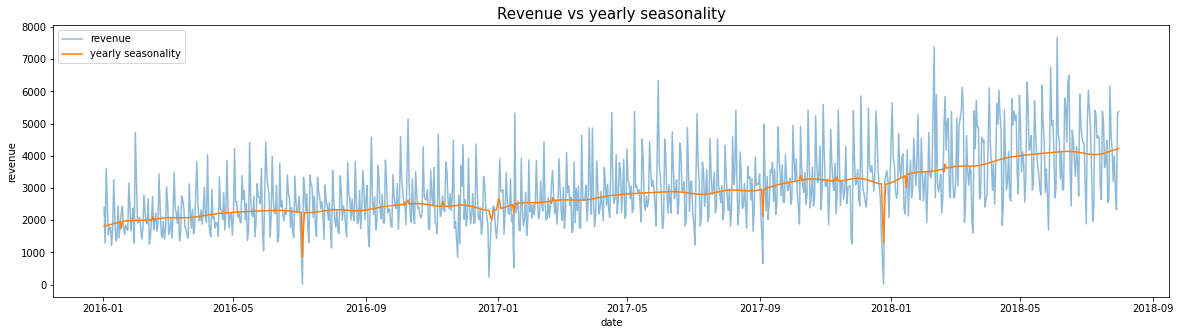

In [22]:
# plot yearly seasonality
plt.figure(figsize=(20,5))

plot_data = train_data[ train_data['date']>='2016-01-01' ]
year_seasonality = np.expm1(plot_data['log_year_seasonality'] + plot_data['log_trend'])
predicted_revenue = np.expm1(plot_data['log_weekly_seasonality'] + plot_data['log_year_seasonality'] + plot_data['log_trend'])

ax1 = sns.lineplot(x=plot_data['date'], y=plot_data['revenue'], label='revenue', alpha=0.5)
ax2 = sns.lineplot(x=plot_data['date'], y=year_seasonality, label='yearly seasonality')
#ax3 = sns.lineplot(x=plot_data['date'], y=predicted_revenue, label='predicted')

plt.title('Revenue vs yearly seasonality', fontsize=15)
plt.legend()

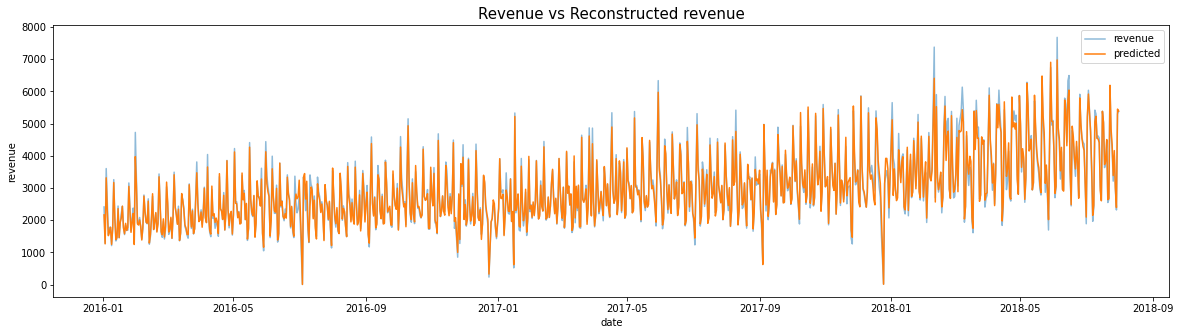

In [23]:
# reconstruct the time series
plt.figure(figsize=(20,5))

plot_data = train_data[ train_data['date']>='2016-01-01' ]
year_seasonality = np.expm1(plot_data['log_year_seasonality'] + plot_data['log_trend'])
predicted_revenue = np.expm1(plot_data['log_weekly_seasonality'] + plot_data['log_year_seasonality'] + plot_data['log_trend'])

ax1 = sns.lineplot(x=plot_data['date'], y=plot_data['revenue'], label='revenue', alpha=0.5)
ax2 = sns.lineplot(x=plot_data['date'], y=predicted_revenue, label='predicted')

plt.title('Revenue vs Reconstructed revenue', fontsize=15)
plt.legend()

In [24]:
# def SMAPE
def smape(y_true, y_pred):
    return 1/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


In [25]:
# report loss on training set
train_y = train_data['revenue']
train_pred = np.expm1(train_data['log_weekly_seasonality'] + train_data['log_year_seasonality'] + train_data['log_trend'])

print('Training MAPE: {:.2%}'.format(mean_absolute_percentage_error(train_y, train_pred)))
print('Training SMAPE: {:.2%}'.format(smape(train_y, train_pred)))

Training MAPE: 3.82%
Training SMAPE: 3.79%


### trend prediction
To make a forecast on future period, we still need the baseline trend analysis. <br>
<br>
Ideally this needs to be done with exogenous factors - external factors such as economy, industry, and competition, as well as internal factors such as plans of expansion. However, for this exercise, we don't have such information available. We will do a vanilla estimation of trend analysis.

## to be continued...